# M6_AI2: Accidentes cerebrovasculares
#### Autor: Leandro Gutierrez
#### Este documento intenta dar respuesta a la actividad 2 propuesta en el Modulo **Técnicas de Machine Learning** del **Master en Big Data y Ciencia de Datos**. En él se describirán cada uno de los enunciados postulados y los resultados obtenidos utilizando Python y Google Colab.
#### Noviembre 10, 2024

# Enunciado
### Contexto
Según la Organización Mundial de la Salud (OMS), el accidente cerebrovascular es la segunda causa principal de muerte a nivel mundial, responsable de, aproximadamente, el 11% del total de muertes.
Un accidente cerebrovascular ocurre cuando el suministro de sangre a una parte del cerebro se interrumpe o se reduce, lo que impide que el tejido cerebral reciba oxígeno y nutrientes. Las células cerebrales comienzan a morir en minutos.

Este conjunto de datos se utiliza para predecir si es probable que un paciente sufra un accidente cerebrovascular en función de los parámetros de entrada como el sexo, la edad, diversas enfermedades y el tabaquismo. Cada fila de datos proporciona información relevante sobre el paciente.

Información de atributos: 

- Id: identificador único. 
- Gender: "Masculino", "Femenino" u "Otro". 
- Age: edad del paciente. 
- Hypertension: 0 si el paciente no tiene hipertensión, 1 si el paciente tiene hipertensión.
- Heart_disease: 0 si el paciente no tiene ninguna enfermedad cardíaca, 1 si el paciente tiene una enfermedad cardíaca. 
- Ever_married: si ha estado alguna vez casado: "No" o "Yes". 
- Work_type: "Children/Cuidado de hijos", "Govt_job/Funcionario del Gobierno", "Never_worked/Nunca ha trabajado", "Private/trabajador por cuenta ajena" o "Self-employeed/Trabajador por cuenta propia". 
- Residence_type: "Rural" o "Urbano". 
- Avg_glucose_level: nivel medio de glucosa en sangre. 
- Bmi: índice de masa corporal (IMC). 
- Smoking_status: "Fue fumador", "Nunca ha fumado", "Fuma actualmente" o "Desconocido". 
- Stroke: 1 si el paciente tuvo un accidente cerebrovascular o 0 si no lo tuvo. 

### Con todos estos datos, os pedimos lo siguiente:
1. Preprocesado: 
   - Convertir todas las variables categóricas a numéricas (gender, ever_married, work_type, residence_type, smoking_status). 
   - Existen 1544 personas de las que se desconoce si fuman o no; vamos a asignar también un número para esta posibilidad. 
   - Existen 201 personas de las que se desconoce su BMI (IMC); vamos a eliminar estos casos para la generación del modelo al tratarse de un bajo porcentaje (4%).
   - Escalar los datos para su uso por el algoritmo.
2. Generar un modelo con el algoritmo de KNN.
3. Evaluación del modelo
   - Calcula el Accuracy.
   - Grafica la ROC-Curve.
   - Grafica la Confusion-Matrix.
   - Comenta los resultados.


# Solución

## 1 - Sanitización y preprocesado

### Carga de datos

In [1]:
# importamos las librerias
import pandas as pd
import matplotlib.pyplot as plt
import numpy
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc

# definimos el path donde buscar los datos
path = 'data/health.csv'

# creamos dataframe
df_org = pd.read_csv(path, sep=',', decimal='.')

df_org = df_org.rename(columns={"Residence_type": "residence_type"})

In [2]:
# previsualizamos los datos
df_org.head(5)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [3]:
# copiamos dataframe para no alterar original
df = df_org.copy()

### Análisis del dataset

In [4]:
df.shape

(5110, 12)

Nuestro dataset cuenta con un total de 5110 observaciones y 12 variables.

In [5]:
df.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

Encontramos 201 valores nulos en la columna `bmi` (Indice de Masa corporal).

In [6]:
# resumen de los datos
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB
None


### Tratamiento de los datos

En primer lugar controlaremos la cantidad de valores únicos que tiene cada una de las columnas categóricas de nuestro dataset

In [7]:
print("gender - posibles valores:", df['gender'].nunique())
print("ever_married - posibles valores:", df['ever_married'].nunique())
print("work_type - posibles valores:", df['work_type'].nunique())
print("residence_type - posibles valores:", df['residence_type'].nunique())
print("smoking_status - posibles valores:", df['smoking_status'].nunique())

gender - posibles valores: 3
ever_married - posibles valores: 2
work_type - posibles valores: 5
residence_type - posibles valores: 2
smoking_status - posibles valores: 4


Veamos la distribución de valores en cada columna

In [8]:
print(df['gender'].value_counts())
print(df['ever_married'].value_counts())
print(df['work_type'].value_counts())
print(df['residence_type'].value_counts())
print(df['smoking_status'].value_counts())
print(df['stroke'].value_counts())

gender
Female    2994
Male      2115
Other        1
Name: count, dtype: int64
ever_married
Yes    3353
No     1757
Name: count, dtype: int64
work_type
Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: count, dtype: int64
residence_type
Urban    2596
Rural    2514
Name: count, dtype: int64
smoking_status
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: count, dtype: int64
stroke
0    4861
1     249
Name: count, dtype: int64


Se puede notar que existen 1544 observaciones con valor `Unknown` para el campo `smoking_status`, necesitamos asginarles un valor. Como vimos en las clases teóricas existen diferéntes métodos para estimar un posible valor a cada observación del dataset, a manera de simplificar el análisis y avanzar con el enunciado elegimos hacerlo mediante el uso de la **moda** de la variable, es decir, obtendremos la moda de la variable `smoking_status` y asignaremos este valor a las lecturas faltantes.

También es necesario mencionar que tenemos un desbalance importante en nuestras clases, es decir en la variable a predecir `stroke`, volveremos sobre este punto más adelante en el trabajo.

In [9]:
df['smoking_status'].mode()

0    never smoked
Name: smoking_status, dtype: object

In [10]:
df.loc[df['smoking_status'] == 'Unknown', 'smoking_status'] = 'never smoked'

Procedemos a realizar una **numerización** de las variables categóricas, es decir realizaremos un encoding de los campos categóricos a enteros para que el algoritmo KNN pueda trabajar con ellos

In [11]:
# creamos columnas auxiliares con los encondings
df['gender_r'] = df['gender'].astype('category').cat.codes
df['ever_married_r'] = df['ever_married'].astype('category').cat.codes
df['work_type_r'] = df['work_type'].astype('category').cat.codes
df['residence_type_r'] = df['residence_type'].astype('category').cat.codes
df['smoking_status_r'] = df['smoking_status'].astype('category').cat.codes

# hacemos un pequeño control 
df.head(10)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke,gender_r,ever_married_r,work_type_r,residence_type_r,smoking_status_r
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1,1,1,2,1,0
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1,0,1,3,0,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1,1,1,2,0,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1,0,1,2,1,2
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1,0,1,3,0,1
5,56669,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1,1,1,2,1,0
6,53882,Male,74.0,1,1,Yes,Private,Rural,70.09,27.4,never smoked,1,1,1,2,0,1
7,10434,Female,69.0,0,0,No,Private,Urban,94.39,22.8,never smoked,1,0,0,2,1,1
8,27419,Female,59.0,0,0,Yes,Private,Rural,76.15,NaN,never smoked,1,0,1,2,0,1
9,60491,Female,78.0,0,0,Yes,Private,Urban,58.57,24.2,never smoked,1,0,1,2,1,1


Ahora realizaremos un escalado de los campos originalmente numéricos `age`, `avg_glucose_level` y `bmi`

In [12]:
# instanciamos el scaler
scaler = StandardScaler()

# escalamos las columnas age, avg_glucose_level y bmi
columns_to_scale = ['age', 'avg_glucose_level', 'bmi']
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

In [13]:
# checkeamos los valores escalados
print (round(df["avg_glucose_level"].mean(),2))
print (round(df["avg_glucose_level"].std(),2))

# visualizamos nuestro dataset
df.head()

0.0
1.0


,id,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke,gender_r,ever_married_r,work_type_r,residence_type_r,smoking_status_r
0,9046,Male,1.051434,0,1,Yes,Private,Urban,2.706375,0.981345,formerly smoked,1,1,1,2,1,0
1,51676,Female,0.786070,0,0,Yes,Self-employed,Rural,2.121559,NaN,never smoked,1,0,1,3,0,1
2,31112,Male,1.626390,0,1,Yes,Private,Rural,-0.005028,0.459269,never smoked,1,1,1,2,0,1
3,60182,Female,0.255342,0,0,Yes,Private,Urban,1.437358,0.701207,smokes,1,0,1,2,1,2
4,1665,Female,1.582163,1,0,Yes,Self-employed,Rural,1.501184,-0.623083,never smoked,1,0,1,3,0,1


Nos queda como paso final de sanitización la eliminación de las observaciones cuyos valores de **IMC** son **NA**

In [14]:
# eliminamos valores na
df = df.dropna()

In [15]:
# realizamos un pequeño control
df.isna().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
gender_r             0
ever_married_r       0
work_type_r          0
residence_type_r     0
smoking_status_r     0
dtype: int64

In [16]:
# checkeamos forma del df
df.shape

(4909, 17)

Hasta este momento hemos hecho las siguientes modificaciones:
- Asignamos a cada valor faltante `unknown` de la columna `smoking_status` la media del valor de la columna, la cual es `never_smoked`.
- Codificamos de manera númerica cada una de las columnas de tipo categóricas.
- Estandarizamos las variables numéricas `age`, `avg_glucose_level` y `bmi`, escalandolas con `media = 0` y `desviación std = 1`
- Eliminamos las observaciones cuyos valores de `bmi` (**imc**) eran desconocidos (`NA`)

## 2 - Generación del modelo de KNN

Habiendo realizado los trabajos de preprocsamiento y sanitización requeridos procedemos a la creación del modelo KNN y a su posterior análisis

In [17]:
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve

Seleccionaremos primero nuestras variables predictoras sanitizadas y la variable objetivo a utilizar

In [18]:
# creamos dos dfs auxiliares
features = df[['gender_r', 'ever_married_r', 'work_type_r', 'residence_type_r', 'smoking_status_r', 'smoking_status_r', 'bmi', 'avg_glucose_level', 'heart_disease', 'hypertension', 'age']].copy()
target = df.loc[:,'stroke']

Procedemos a encontrar un candidato adecuado para el valor de $K$, lo haremos mediante un método iterativo de validación cruzada, es decir crearemos múltiples modelos cada uno con un valor diferente de K, para luego visualizar y comparar la `accuracy` de cada uno de ellos

In [19]:
weights="uniform"
metric="minkowski"

preds_list = []
score_list = []
k_list = []

# iteramos por valores de k impares de 1 a 20
for k in list(range(1, 20, 2)):
  knn_model = KNeighborsClassifier(n_neighbors=k, weights=weights, metric=metric)
  preds_aux = cross_val_predict(knn_model, features, target, cv=3, method="predict", n_jobs=3)
  score_aux = cross_val_score(knn_model, features, target, cv=3, scoring="accuracy")
  k_list.append(k)
  preds_list.append(preds_aux)
  score_list.append(score_aux.mean())
  
df_scores = pd.DataFrame({"K":k_list, 
    "score":score_list
})

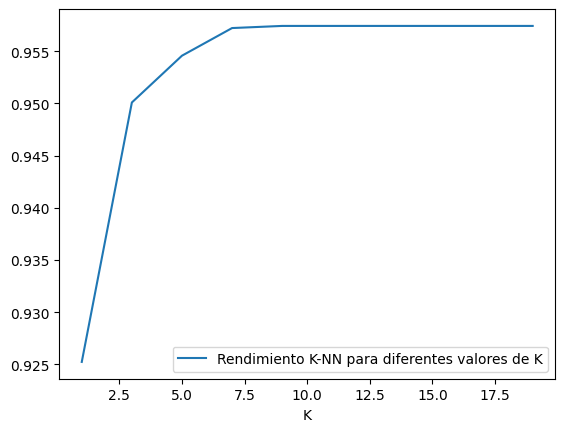

In [20]:
# graficamos la variacion de accuracy con cada valor de k
df_scores.set_index("K")["score"].plot(label="Rendimiento K-NN para diferentes valores de K")
plt.legend()
plt.show()

Vemos que tenemos un pico de rendimiento cercano a $K = 7$, utilizaremos este valor y analizaremos sus métricas de bondad

## 3 - Evaluación del modelo

Una vez que tenemos nuestro modelo y su parametro $K$ definido procedemos a la evalución del mismo, en este caso lo haremos mediante el método de cross-validation utilizando 5 capas (folds) y determinaremos el accuracy de cada una de ellas, para luego encontrar la media general

In [21]:
k = 7
folds = 5

# creamos el clasificador
knn_model = KNeighborsClassifier(n_neighbors=k, weights=weights, metric=metric)
preds1 = cross_val_predict(knn_model, features, target, cv=folds, method="predict", n_jobs=3)
score1 = cross_val_score(knn_model, features, target, cv=folds, scoring="accuracy", n_jobs=3)
probs1 = cross_val_predict(knn_model, features, target, cv=folds, method="predict_proba", n_jobs=3)

# vemos accuracy por capa
print("Accuracy por capa: " , score1)
print("Accuracy media: ", numpy.mean(score1))

Accuracy por capa:  [0.95621181 0.95621181 0.95315682 0.95621181 0.95820591]
Accuracy media:  0.9559996346053634


Podemos notar que obtenemos valores de `accuracy` altos, al rededor de **0.95**. Sabemos además que ésta no es la única métrica que nos interesa evaluar, procedemos a visualizar la matriz de confusión de nuestro modelo y a obtener los valores de `precision` y `alcance`

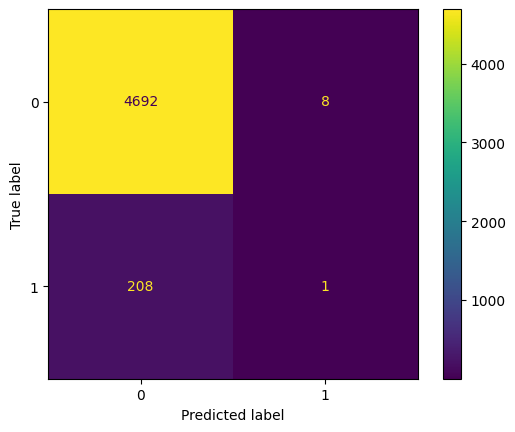

In [22]:
# creamos la matriz de confusion
cm = confusion_matrix(target, preds1)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

Podemos notar que si bien nuestro modelo tiene una `accuracy` alta, dado que es capaz de predecir correctamente la mayoría de los casos negativos siendo esta la clase mayoritaria, carece de sensibilidad (`recall`) para detectar los casos positivos reales, detectando solamente 1 de los 209 casos afirmativos totales.

Recordemos como se calculan `accuracy`, `recall` y `precision`

$$ accuracy = (TP+TN)/Total Observaciones$$
$$ precision=TP/(TP+FP) $$
$$ recall=TP/(TP+FN) $$

Volvamos un minuto al desbalance de clases con el que lidiamos, pudimos ver que la variable a predecir `stroke` posee muchas mas observaciones con valor igual a 0 (**False**) que las veces que toma el valor 1 (**True**), lo que nos indica que nuestro dataset está fuertemente desbalanceado, veamos a continuación estas proporciones

In [23]:
df["stroke"].value_counts()/len(df)

stroke
0    0.957425
1    0.042575
Name: count, dtype: float64

El 95.7% de los pacientes analizados no sufrieron un Accidente Cerebro Vascular, mientras que solo un 4.3% restante si lo hizo. Lo que significa que si nuestro modelo predijese siempre un posible **caso de ACV como False** acertaría un 95% de las veces pero **fallaría la mayoría de las veces** en predecir los casos en los que el accidente cerebro vascular si sucederá.

Para poder mejorar nuestro modelo primero analicemos las curvas de `precision` y `recall` para encontrar un umbral o threshold adecuado a nuestro problema. Sabemos que por defecto KNN utiliza como umbral de probabilidad para clasificación el `0.5`, por lo que de manera iterativa hiremos variando este umbral y analizando los indicadores que obtenemos a cada paso

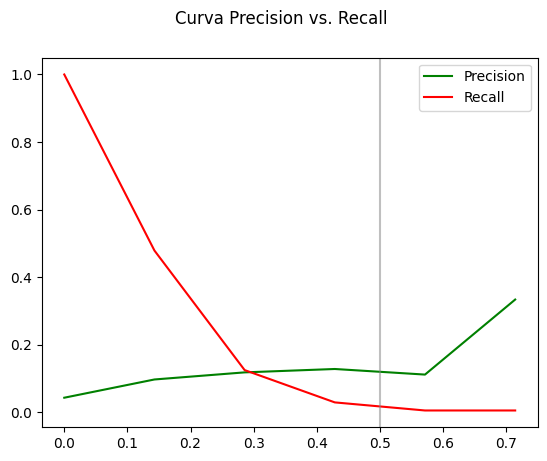

In [24]:
# obtenemos las curvas precision y recall
precision, recall, threshold = precision_recall_curve(target,probs1[:,1])

# dibujamos las curvas
plt.plot(threshold, precision[:-1], c="green", label="Precision")
plt.plot(threshold, recall[:-1], c="red", label="Recall")
plt.axvline(0.5, alpha=0.5, c="gray")
plt.suptitle("Curva Precision vs. Recall")
plt.legend()
plt.show()

Analizaremos que sucede si utilizamos diferentes valores de `umbral` o `threshold` en la detección de clases

In [25]:
# creamos un df auxiliar con las probabilidades de cada clase de cada observacion
df_dict = {"prob_class0": probs1[:,0],
           "prob_class1": probs1[:,1],
           "preds":preds1}

In [26]:
df_probs = pd.DataFrame(df_dict)
df_probs.head()

,prob_class0,prob_class1,preds
0,0.857143,0.142857,0
1,1.000000,0.000000,0
2,0.857143,0.142857,0
3,0.857143,0.142857,0
4,0.714286,0.285714,0


In [27]:
df_probs["preds_10"] = 0
df_probs["preds_20"] = 0
df_probs["preds_30"] = 0

# creamos tres posibles clasificadores con diferentes thresholds
df_probs.loc[df_probs["prob_class1"]>0.1, "preds_10"] = 1
df_probs.loc[df_probs["prob_class1"]>0.2, "preds_20"] = 1
df_probs.loc[df_probs["prob_class1"]>0.3, "preds_30"] = 1

df_probs

,prob_class0,prob_class1,preds,preds_10,preds_20,preds_30
0,0.857143,0.142857,0,1,0,0
1,1.000000,0.000000,0,0,0,0
2,0.857143,0.142857,0,1,0,0
3,0.857143,0.142857,0,1,0,0
4,0.714286,0.285714,0,1,1,0
...,...,...,...,...,...,...
4904,1.000000,0.000000,0,0,0,0
4905,0.857143,0.142857,0,1,0,0
4906,1.000000,0.000000,0,0,0,0
4907,0.857143,0.142857,0,1,0,0


A continuación analizaremos las métricas `alcance` y `precision` para cada umbral propuesto

### Threshold = 30

Informe de Clasificación:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      4700
           1       0.13      0.03      0.05       209

    accuracy                           0.95      4909
   macro avg       0.54      0.51      0.51      4909
weighted avg       0.92      0.95      0.93      4909



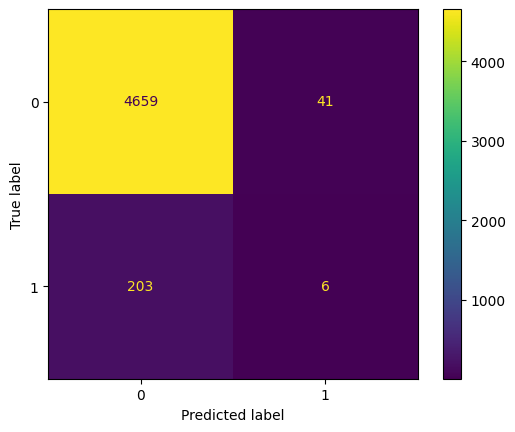

In [28]:
preds30 = df_probs["preds_30"].values
cm = confusion_matrix(target, preds30)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
print(f"Informe de Clasificación:\n"
      f"{classification_report(target, preds30)}")


### Threshold = 20

Informe de Clasificación:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      4700
           1       0.12      0.12      0.12       209

    accuracy                           0.92      4909
   macro avg       0.54      0.54      0.54      4909
weighted avg       0.93      0.92      0.92      4909



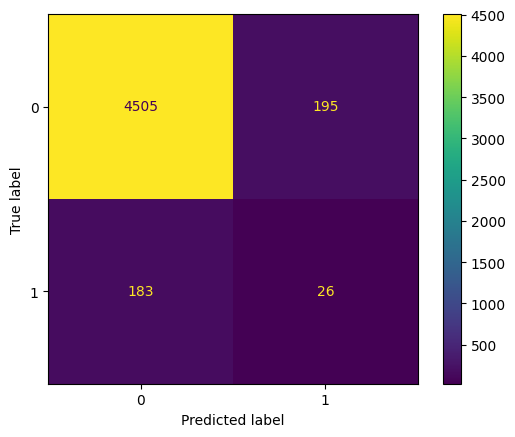

In [29]:
preds20 = df_probs["preds_20"].values
cm = confusion_matrix(target, preds20)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
print(f"Informe de Clasificación:\n"
      f"{classification_report(target, preds20)}")


### Threshold = 10

Informe de Clasificación:
              precision    recall  f1-score   support

           0       0.97      0.80      0.88      4700
           1       0.10      0.48      0.16       209

    accuracy                           0.79      4909
   macro avg       0.53      0.64      0.52      4909
weighted avg       0.93      0.79      0.85      4909



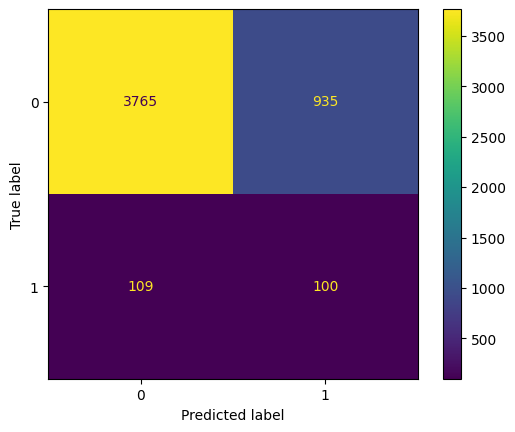

In [30]:
preds10 = df_probs["preds_10"].values
cm = confusion_matrix(target, preds10)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
print(f"Informe de Clasificación:\n"
      f"{classification_report(target, preds10)}")


Podemos observar como al disminuir el umbral de detección de `stroke` la cantidad de casos de tipo `falso negativo` disminuyen, mejorando el `recall` de nuestro modelo, a su vez tambien notamos que la cantidad de `falsos positivos` aumenta considerablemente, perjudicando la `precisión` del mismo.

El balance correcto entre `recall` y `precision` lo determinará el caso de uso. Si hablamos de `pacientes` y `riesgo de vida` seguramente ponderemos tener el mejor alcance (recall) posible en detrimento de la precisión, asumiendo que se antepone el riesgo de vida por sobre el coste de tratamientos preventivos.

Considerando lo mencionado se determina que nuestro modelo ideal debe tener el `recall` lo mas alto posible, haciendo que nos inclinemos por disminuir el umbral de selectividad a **0.10**, en detrimento de la `precisión`.

Veamos ROC y AUC de nuestro modelo con el nuevo umbral propuesto

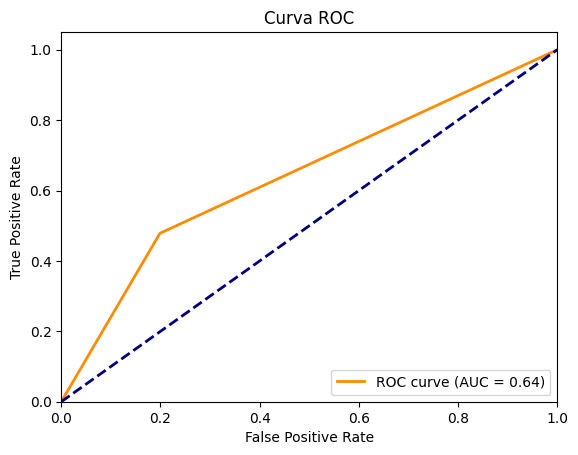

In [31]:
fpr, tpr, thresholds = roc_curve(target, preds10)

# Calcular el AUC
roc_auc = auc(fpr, tpr)

# Graficar la Curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Línea de referencia (curva ROC aleatoria)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

Obtenemos un **AUC** de **0.65** lo cual nos indica que estamos ante un modelo con capacidades moderadas.

## Consideraciones 

A estas alturas es necesario mencionar que se consideró la posibilidad de hacer un split del dataset original en particiones `test` y `train` al comienzo del trabajo práctico, a modo de poder analizar el rendimiento del modelo una vez resuelta la selección final tanto del valor `K` como del `umbral` de predicción. 

Se hubiese hecho un split definiendo un `stratify` en función de la variable objetivo `stroke`, de manera de guardar propocionalidad entre los casos positivos y negativos en las particiones de `train` y `test`. 

Una vez hecho el análisis anteriormente visto solo con datos de `train` se procedería a la evaluación del modelo ya con datos de la partición `test`. A causa del reducido tiempo para la realización del trabajo se deja este comentario a modo de consideración personal.